I'm going to forecast GE stock close price using LSTM, you can see the dataset [here](https://finance.yahoo.com/quote/GE/)

This notebook is an assignment on Dicoding [Belajar Pengembangan Machine Learning](https://www.dicoding.com/academies/185) course
Created by [Satria Kemal](https://www.dicoding.com/users/codesigma)

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from sklearn.preprocessing import StandardScaler

import os

# Data Preparation

Upload dataset and read dataset

In [2]:
csv_file = files.upload()

Saving GE.csv to GE (3).csv


In [3]:
filename = list(csv_file.keys())[0]
df = pd.read_csv(f"/content/{filename}")
df.Date = df.Date.apply(lambda x: pd.to_datetime(x)) #Convert type of 'Date' from string to pd.datetime
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.751202,0.763722,0.743690,0.748698,0.126684,2156544
1,1962-01-03,0.744942,0.744942,0.738682,0.741186,0.125413,1477632
2,1962-01-04,0.741186,0.747446,0.726162,0.732422,0.123930,1837056
3,1962-01-05,0.732422,0.733674,0.701122,0.713642,0.120752,2725632
4,1962-01-08,0.713642,0.713642,0.691106,0.712390,0.120540,3095040
...,...,...,...,...,...,...,...
14978,2021-07-02,13.540000,13.540000,13.310000,13.360000,13.360000,33159900
14979,2021-07-06,13.280000,13.320000,12.820000,12.920000,12.920000,70638800
14980,2021-07-07,12.880000,13.080000,12.740000,12.980000,12.980000,61060500
14981,2021-07-08,12.730000,12.940000,12.610000,12.870000,12.870000,53822800


****

**Plot data**

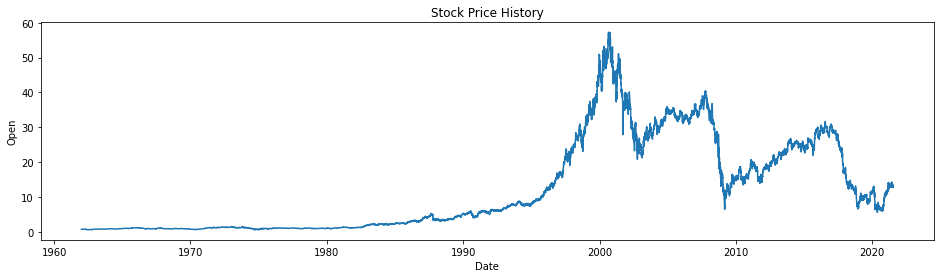

In [4]:
plt.figure(figsize=(16,4))
plt.title("Stock Price History")
sns.lineplot(x = "Date", y = "Open", data = df)

**Scalling Data**

In [5]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(df.Close).reshape(-1, 1))
df.Close = scaler.transform(np.array(df.Close).reshape(-1, 1))

**Windowing**

In [6]:
X_train = []
y_train = []
X_train.append(df.Close[:10].values)

pv = 0
while pv + 10 < len(df.Close):
  X_train.append(list(df.Close[pv:pv+10].values))
  y_train.append(df.Close[pv+11])
  pv += 11

In [15]:
X_train = X_train[:-1] #drop the last window because there's not enough data

In [8]:
#Reshape Data for training process
X_train = np.array(X_train).reshape(-1, 1, 10) 
y_train = np.array(y_train)

# Modelling

In [9]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(10, input_shape = (1, 10), return_sequences=True),
  
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(64, activation="relu"), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=optimizer,
              metrics=["mae"])

In [10]:
#make folder model
model._name = "temperature_timeseries_LSTM"
model_save_path = "./models/"
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
checkpoint = ModelCheckpoint(os.path.join(model_save_path, model.name+".h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_mae', mode='min')

history = model.fit(X_train, 
                    y_train, 
                    validation_split = 0.2, 
                    epochs=10, 
                    steps_per_epoch = len(X_train)//8,
                    callbacks=[checkpoint]
                   )

Epoch 1/10
170/170 [==============================] - 3s 5ms/step - loss: 0.1393 - mae: 0.1393 - val_loss: 0.0926 - val_mae: 0.0926

Epoch 00001: val_mae improved from inf to 0.09258, saving model to ./models/temperature_timeseries_LSTM.h5
Epoch 2/10
170/170 [==============================] - 0s 3ms/step - loss: 0.0890 - mae: 0.0890 - val_loss: 0.1334 - val_mae: 0.1334

Epoch 00002: val_mae did not improve from 0.09258
Epoch 3/10
170/170 [==============================] - 0s 2ms/step - loss: 0.1043 - mae: 0.1043 - val_loss: 0.1769 - val_mae: 0.1769

Epoch 00003: val_mae did not improve from 0.09258
Epoch 4/10
170/170 [==============================] - 0s 2ms/step - loss: 0.0906 - mae: 0.0906 - val_loss: 0.1225 - val_mae: 0.1225

Epoch 00004: val_mae did not improve from 0.09258
Epoch 5/10
170/170 [==============================] - 0s 2ms/step - loss: 0.0827 - mae: 0.0827 - val_loss: 0.1247 - val_mae: 0.1247

Epoch 00005: val_mae did not improve from 0.09258
Epoch 6/10
170/170 [========

In [17]:
#10% scale
(df.Close.max() - df.Close.min()) *.1

0.4319064624821476

# Plotting Result

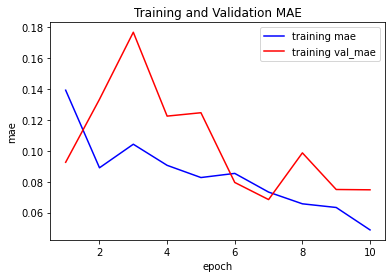

In [13]:
acc = history.history["mae"]
val_acc = history.history["val_mae"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, acc, color="blue", label="training mae")
plt.plot(epochs, val_acc, color="red", label="training val_mae")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("mae")
plt.title("Training and Validation MAE")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

**Plot true label and predicted label, just to check if the model works well**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'predicted value')

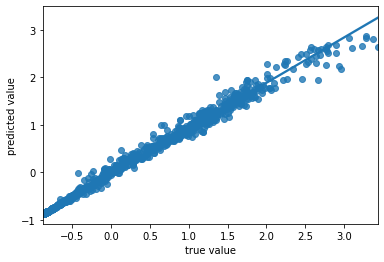

In [14]:
sns.regplot(y_train, [x[0, 0] for x in model.predict(X_train)])
plt.xlabel("true value")
plt.ylabel("predicted value")
